# Testing Response Calculations for eXTP LAD

Let's test our response calculations on eXTP LAD simulations!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ImportError:
    print("No seaborn installed. Oh well.")
    
import numpy as np 
import pandas as pd
import astropy.io.fits as fits
import sherpa.astro.ui as ui
import astropy.modeling.models as models
from astropy.modeling.fitting import _fitter_to_model_params
from scipy.special import gammaln as scipy_gammaln

from clarsach.respond import RMF, ARF



failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
datadir = "./"

In [3]:
ui.load_data(id="p1", filename=datadir+"eXTP_LAD.fak")

read RMF file ./LAD_40mod_200eV_rbn.rsp


In [4]:
d = ui.get_data("p1")

In [5]:
# conversion factor from keV to angstrom
c = 12.3984191

# This is the data in counts
counts = d.counts
channel = d.channel

exposure = d.exposure

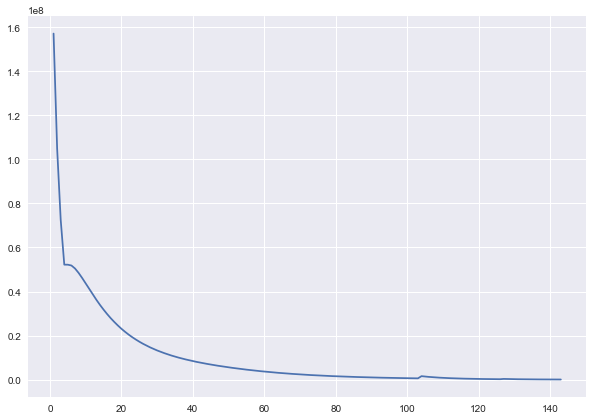

In [6]:
plt.figure(figsize=(10,7))
plt.plot(channel, counts)

In [7]:
rmf_list = fits.open(datadir+"LAD_40mod_200eV_rbn.rsp")
rmf_list[1].header["TUNIT2"]

'keV'

In [8]:
rmf_list.info()

Filename: ./LAD_40mod_200eV_rbn.rsp
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      10   ()      
  1  MATRIX      BinTableHDU     61   2048R x 6C   [E, E, I, 2I, 2I, PE(135)]   
  2  EBOUNDS     BinTableHDU     52   143R x 3C   [J, E, E]   


In [9]:
rmf_list["EBOUNDS"].columns

ColDefs(
    name = 'CHANNEL'; format = 'J'
    name = 'E_MIN'; format = 'E'; unit = 'keV'
    name = 'E_MAX'; format = 'E'; unit = 'keV'
)

In [10]:
energ_lo = rmf_list["MATRIX"].data.field("ENERG_LO")
energ_hi = rmf_list["MATRIX"].data.field("ENERG_HI")

bin_lo = rmf_list["EBOUNDS"].data.field("E_MIN")
bin_hi = rmf_list["EBOUNDS"].data.field("E_MAX")
bin_mid = bin_lo + (bin_hi - bin_lo)/2.

In [11]:
rmf = d.get_rmf()
rmf

<DataRMF data set instance './LAD_40mod_200eV_rbn.rsp'>

In [12]:
from clarsach.models.powerlaw import Powerlaw

In [13]:
pl = Powerlaw(norm=1.0, phoindex=2.0)

In [14]:
m = pl.calculate(ener_lo=energ_lo, ener_hi=energ_hi)

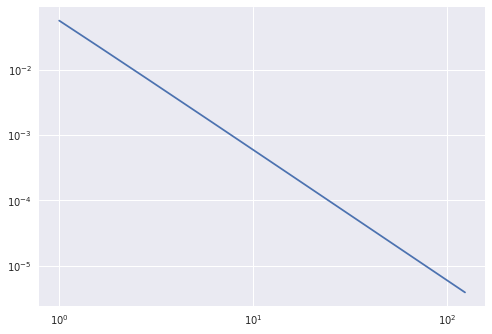

In [15]:
plt.figure()
plt.loglog(energ_lo, m)

In [16]:
len(m)

2048

In [17]:
m_rmf = rmf.apply_rmf(m)

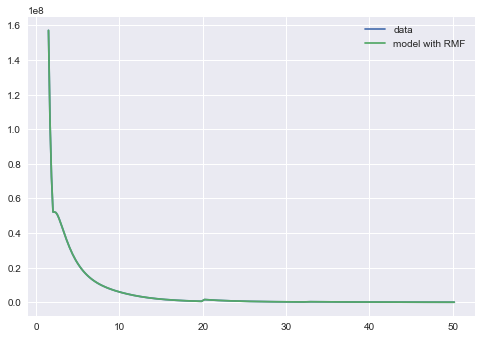

In [18]:
plt.figure()
plt.plot(bin_mid, counts, label="data")
plt.plot(bin_mid, m_rmf*1e5, label="model with RMF")
plt.legend()

In [19]:
class PoissonLikelihood(object):
    
    def __init__(self, x_low, x_high, y, model, arf=None, rmf=None, exposure=1.0):
        self.x_low = x_low
        self.x_high = x_high
        self.y = y
        self.model = model
        self.arf = arf
        self.rmf = rmf
        self.exposure = exposure
        
    def evaluate(self, pars):
        # store the new parameters in the model

        self.model.norm = pars[0]
        self.model.phoindex = pars[1]
        
        # evaluate the model at the positions x
        mean_model = self.model.calculate(self.x_low, self.x_high)

        # run the ARF and RMF calculations
        if self.arf is not None:
            m_arf = self.arf.apply_arf(mean_model)
            
        else:
            m_arf = mean_model
            
        if self.rmf is not None:
            ymodel = self.rmf.apply_rmf(m_arf)
        else:
            ymodel = mean_model
                
        ymodel += 1e-20
        
        ymodel *= self.exposure
        # compute the log-likelihood
        loglike = np.sum(-ymodel + self.y*np.log(ymodel) \
               - scipy_gammaln(self.y + 1.))

        if np.isfinite(loglike):
            return loglike
        else:
            return -1.e16

    def __call__(self, pars):
        l = -self.evaluate(pars)
        #print(l)
        return l



In [20]:
loglike = PoissonLikelihood(energ_lo, energ_hi, counts, pl, arf=None, rmf=rmf, exposure=exposure)
loglike([1.0, 2.0])

1252.2741299574845

In [21]:
from scipy.optimize import minimize

In [22]:
opt = minimize(loglike, [1.0, 2.0], method="powell")

In [23]:
opt

   direc: array([[ 1.,  0.],
       [ 0.,  1.]])
     fun: 1249.8817882679286
 message: 'Optimization terminated successfully.'
    nfev: 88
     nit: 2
  status: 0
 success: True
       x: array([ 0.99995508,  2.00002944])

In [24]:
m_fit = pl.calculate(energ_lo, energ_hi)
m_fit_rmf = rmf.apply_rmf(m_fit) * exposure

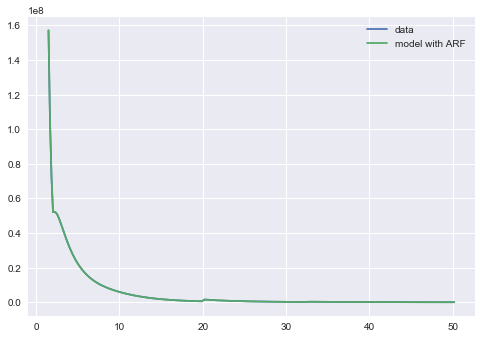

In [25]:
plt.figure()
plt.plot(bin_mid, counts, label="data")
plt.plot(bin_mid, m_fit_rmf, label="model with ARF")
plt.legend()

In [26]:
def rmf_fold(spec, rmf, nchannels=None):
    
    #current_num_groups = 0
    #current_num_chans = 0
    
    nchannels = spec.shape[0]
    
    resp_idx = 0
    first_chan_idx = 0
    num_chans_idx =0
    counts_idx = 0
    
    counts = np.zeros(nchannels)
    
    for i in range(nchannels):
        source_bin_i = spec[i]
        current_num_groups = rmf.n_grp[i]
        
        while current_num_groups:
            counts_idx = int(rmf.f_chan[first_chan_idx] - rmf.offset)
            current_num_chans = rmf.n_chan[num_chans_idx]
            
            first_chan_idx += 1
            num_chans_idx +=1 
            
            while current_num_chans:
                counts[counts_idx] += rmf.matrix[resp_idx] * source_bin_i
                counts_idx += 1
                resp_idx += 1
                current_num_chans -= 1
            
            current_num_groups -= 1
            
    return counts


In [27]:
def rmf_fold_vector(spec, rmf, nchannels=None):
    """
    Fold the spectrum through the redistribution matrix.
    
    Parameters
    ----------
    spec : numpy.ndarray
        The (model) spectrum to be folded
        
    rmf : sherpa.RMFData object
        The object with the RMF data
    
    """    
    # get the number of channels in the data
    nchannels = spec.shape[0]
    print('len(nchannels): ' + str(nchannels))

    # an empty array for the output counts
    counts = np.zeros(nchannels)
    
    # index for n_chan and f_chan incrementation
    k = 0
    
    # index for the response matrix incrementation
    resp_idx = 0

    # loop over all channels
    for i in range(nchannels):
        
        # this is the current bin in the flux spectrum to 
        # be folded
        source_bin_i = spec[i]
        
        # get the current number of groups 
        current_num_groups = rmf.n_grp[i]
        
        for j in range(current_num_groups):
            counts_idx = int(rmf.f_chan[k] - rmf.offset)
            current_num_chans = int(rmf.n_chan[k])
            
            k += 1
            
            counts[counts_idx:counts_idx+current_num_chans] += rmf.matrix[resp_idx:resp_idx+current_num_chans] * source_bin_i
            resp_idx += current_num_chans
            
    return counts




In [28]:
# not vectorized version
m_rmf = rmf_fold(m, rmf)
%timeit m_rmf = rmf_fold(m, rmf)

10 loops, best of 3: 114 ms per loop


In [29]:
# vectorized version
m_rmf_v = rmf_fold_vector(m, rmf)
%timeit m_rmf_v = rmf_fold_vector(m, rmf)

len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels): 2048
len(nchannels

In [30]:
# C++ (sherpa) version
m_rmf2 = rmf.apply_rmf(m)
%timeit m_rmf2 = rmf.apply_rmf(m)

10000 loops, best of 3: 118 µs per loop


In [31]:
np.allclose(m_rmf_v[:len(m_rmf2)], m_rmf2)

True

In [32]:
np.allclose(m_rmf[:len(m_rmf2)], m_rmf2)

True

In [33]:
class RMF(object):
    
    def __init__(self, filename):
        
        self._load_rmf(filename)
        pass
    
    def _load_rmf(self, filename):
        """
        Load an RMF from a FITS file.
        
        Parameters
        ----------
        filename : str
            The file name with the RMF file
            
        Attributes
        ----------
        n_grp : numpy.ndarray
            the Array with the number of channels in each 
            channel set
        
        f_chan : numpy.ndarray
            The starting channel for each channel group;
            If an element i in n_grp > 1, then the resulting 
            row entry in f_chan will be a list of length n_grp[i];
            otherwise it will be a single number
            
        n_chan : numpy.ndarray
            The number of channels in each channel group. The same 
            logic as for f_chan applies
            
        matrix : numpy.ndarray
            The redistribution matrix as a flattened 1D vector
            
        energ_lo : numpy.ndarray
            The lower edges of the energy bins
        
        energ_hi : numpy.ndarray
            The upper edges of the energy bins
            
        detchans : int
            The number of channels in the detector
        
        """
        # open the FITS file and extract the MATRIX extension
        # which contains the redistribution matrix and 
        # anxillary information
        hdulist = fits.open(filename)

        # get all the extension names
        extnames = np.array([h.name for h in hdulist])

        # figure out the right extension to use
        if "MATRIX" in extnames:
            h = hdulist["MATRIX"]

        elif "SPECRESP MATRIX" in extnames:
            h = hdulist["SPECRESP MATRIX"]

        data = h.data
        hdr = h.header
        hdulist.close()
        
        # extract + store the attributes described in the docstring 
        n_grp = np.array(data.field("N_GRP"))
        f_chan = np.array(data.field('F_CHAN'))
        n_chan = np.array(data.field("N_CHAN"))
        matrix = np.array(data.field("MATRIX"))

        self.energ_lo = np.array(data.field("ENERG_LO"))
        self.energ_hi = np.array(data.field("ENERG_HI"))
        self.detchans = hdr["DETCHANS"]
        self.offset = self.__get_tlmin(h)

        # flatten the variable-length arrays
        self.n_grp, self.f_chan, self.n_chan, self.matrix = \
                self.__flatten_arrays(n_grp, f_chan, n_chan, matrix)
        
        return
    
    def __get_tlmin(self, h):
        """
        Get the tlmin keyword for `F_CHAN`.
        
        Parameters
        ----------
        h : an astropy.io.fits.hdu.table.BinTableHDU object
            The extension containing the `F_CHAN` column
            
        Returns
        -------
        tlmin : int
            The tlmin keyword
        """
        # get the header
        hdr = h.header
        # get the keys of all 
        keys = np.array(list(hdr.keys()))
        
        # find the place where the tlmin keyword is defined
        t = np.array(["TLMIN" in k for k in keys])
        
        # get the index of the TLMIN keyword
        tlmin_idx = np.hstack(np.where(t))[0]
        
        # get the corresponding value
        tlmin = np.int(list(hdr.items())[tlmin_idx][1])
        
        return tlmin
        
    def __flatten_arrays(self, n_grp, f_chan, n_chan, matrix):
        
        # find all non-zero groups
        nz_idx = (n_grp > 0)
        
        # stack all non-zero rows in the matrix
        matrix_flat = np.hstack(matrix[nz_idx])
        
        # stack all nonzero rows in n_chan and f_chan
        n_chan_flat = np.hstack(n_chan[nz_idx])
        f_chan_flat = np.hstack(f_chan[nz_idx])
        
        nz_idx2 = (n_chan_flat > 0)
        n_chan_flat = n_chan_flat[nz_idx2]
        f_chan_flat = f_chan_flat[nz_idx2]
        
        return n_grp, f_chan_flat, n_chan_flat, matrix_flat
            
    def apply_rmf(self, spec):
        """
        Fold the spectrum through the redistribution matrix.

        The redistribution matrix is saved as a flattened 1-dimensional 
        vector to save space. In reality, for each entry in the flux 
        vector, there exists one or more sets of channels that this 
        flux is redistributed into. The additional arrays `n_grp`, 
        `f_chan` and `n_chan` store this information:
            * `n_group` stores the number of channel groups for each 
              energy bin
            * `f_chan` stores the *first channel* that each channel 
              for each channel set 
            * `n_chan` stores the number of channels in each channel 
              set 
              
        As a result, for a given energy bin i, we need to look up the 
        number of channel sets in `n_grp` for that energy bin. We 
        then need to loop over the number of channel sets. For each 
        channel set, we look up the first channel into which flux 
        will be distributed as well as the number of channels in the 
        group. We then need to also loop over the these channels and 
        actually use the corresponding elements in the redistribution 
        matrix to redistribute the photon flux into channels. 
        
        All of this is basically a big bookkeeping exercise in making 
        sure to get the indices right.
        
        Parameters
        ----------
        spec : numpy.ndarray
            The (model) spectrum to be folded

        Returns
        -------
        counts : numpy.ndarray
            The (model) spectrum after folding, in 
            counts/s/channel

        """    
        
        nchannels = spec.shape[0]

        # an empty array for the output counts
        counts = np.zeros(nchannels)
        
        # index for n_chan and f_chan incrementation
        k = 0

        # index for the response matrix incrementation
        resp_idx = 0

        # loop over all channels
        for i in range(nchannels):
            # this is the current bin in the flux spectrum to
            # be folded
            source_bin_i = spec[i]

            # get the current number of groups 
            current_num_groups = self.n_grp[i]

            # loop over the current number of groups
            for j in range(current_num_groups):

                # get the right index for the start of the counts array 
                # to put the data into
                counts_idx = int(self.f_chan[k] - self.offset)
                # this is the current number of channels to use

                current_num_chans = int(self.n_chan[k])

                k += 1

                # add the flux to the subarray of the counts array that starts with 
                # counts_idx and runs over current_num_chans channels
                counts[counts_idx:counts_idx+current_num_chans] +=  self.matrix[resp_idx:resp_idx+current_num_chans] * \
                                                                    np.float(source_bin_i)
                # iterate the response index for next round
                resp_idx += current_num_chans

        return counts[:self.detchans]



In [34]:
rmf_new = RMF(datadir+"LAD_40mod_200eV_rbn.rsp")
m_rmf = rmf_new.apply_rmf(m)

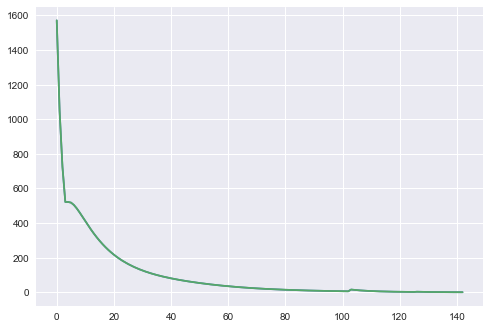

In [35]:
plt.figure()
plt.plot(m_rmf)
plt.plot(m_rmf_v[:len(counts)])

In [36]:
from clarsach import respond

In [37]:
rmf_c = respond.RMF(datadir+"LAD_40mod_200eV_rbn.rsp")

In [38]:
m_rmf_c = rmf_new.apply_rmf(m)

In [39]:
np.allclose(m_rmf_c, m_rmf_v[:len(counts)])

True

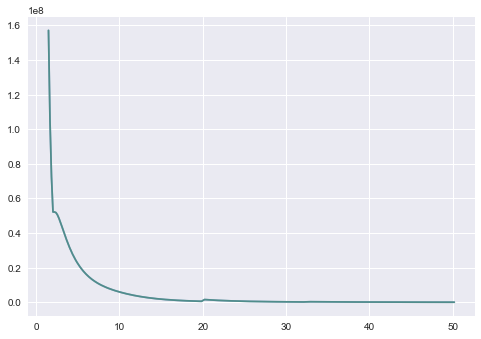

In [40]:
plt.figure()
plt.plot(bin_mid, counts, label="data")
plt.plot(bin_mid, m_rmf_c*exposure, label="model", alpha=0.5)

And this works, toooooooo! 